# Single session example

This notebook goes through an analysis example of GHOST with data from a single session

In [63]:
import os
import subprocess as sp

import ants
import numpy as np
from glob import glob

### Convert DICOM - NIFTI

In [38]:
# DICOM data path
data_path = '../../../data/UNITY_QA_Example_data/DICOM'
session = '20230828'
dicom_path = os.path.join(data_path, session)

# Output path
nii_out = './NIFTI'
if not os.path.exists(nii_out):
    os.makedirs(nii_out)
    cmd = f'dcm2niix -o {nii_out} {dicom_path}'
    print(f"Converting using: {cmd}\n")
    sp.call(cmd, shell=True)

else:
    print(f"{nii_out} directory already exists. Remove to redo conversion.")



Converting using: dcm2niix -o ./NIFTI ../../../data/UNITY_QA_Example_data/DICOM/20230828

Chris Rorden's dcm2niiX version v1.0.20220505  Clang14.0.0 ARM (64-bit MacOS)
Found 5 DICOM file(s)
Convert 1 DICOM as ./NIFTI/20230828_T2_(AXI,_Fast)_20230828083112_5 (112x136x40x1)
Convert 1 DICOM as ./NIFTI/20230828_T2_(COR,_Fast)_20230828083112_6 (112x124x44x1)
Convert 1 DICOM as ./NIFTI/20230828_T2_(SAG,_Fast)_20230828083112_7 (136x124x36x1)
Convert 1 DICOM as ./NIFTI/20230828_FISP_20230828083112_3 (60x74x36x1)
Convert 1 DICOM as ./NIFTI/20230828_T2_(AXI,_Fast)_20230828083112_4 (112x136x40x1)
Conversion required 0.021604 seconds (0.020710 for core code).


### View data

In [39]:
f_axi = glob(nii_out+'/*AXI*.nii*')
f_sag = glob(nii_out+'/*SAG*.nii*')
f_cor = glob(nii_out+'/*COR*.nii*')
f_fisp = glob(nii_out+'/*FISP*.nii*')

Sagittal T2w


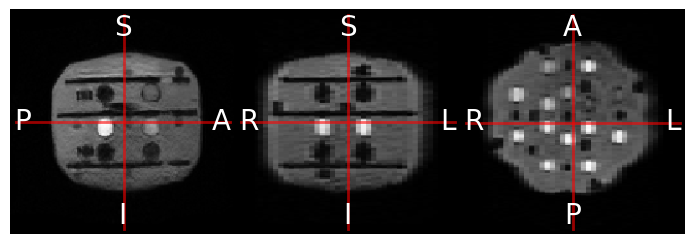

Coronal T2w


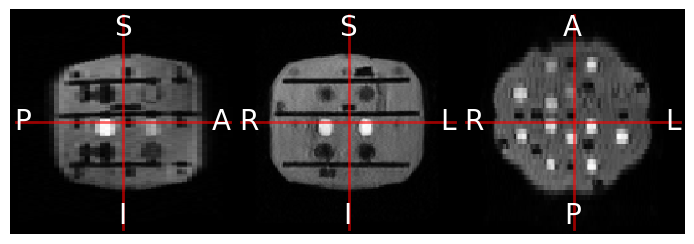

Axial T2w


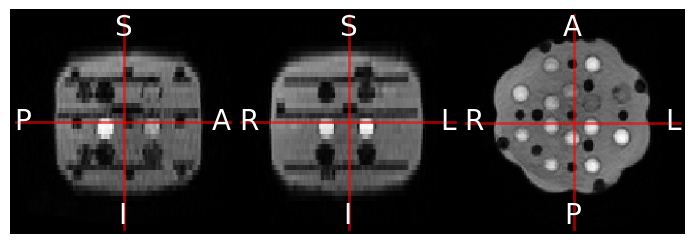

Axial FISP


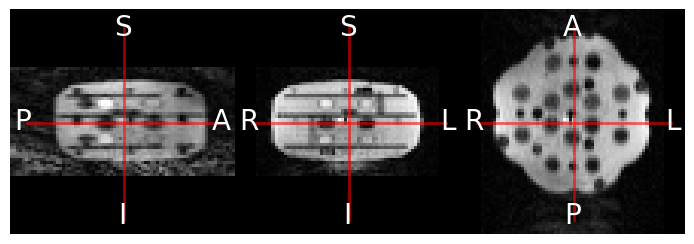

In [40]:
print("Sagittal T2w")
sag = ants.image_read(f_sag[0])
sag.plot_ortho(resample=True, flat=True)

print("Coronal T2w")
cor = ants.image_read(f_cor[0])
cor.plot_ortho(resample=True, flat=True)

print("Axial T2w")
axi = ants.image_read(f_axi[0])
axi.plot_ortho(resample=True, flat=True)

print("Axial FISP")
fisp = ants.image_read(f_fisp[0])
fisp.plot_ortho(resample=True, flat=True)

### Segment ADC, NiCl<sub>2</sub>, and MnCl<sub>2</sub> fiducials


#### 1. Command line interface

In [45]:
!ghost warp_rois -h

usage: ghost warp_rois <input> [<args>]]

Warp ROIs to target image

positional arguments:
  input                 Input image

options:
  -h, --help            show this help message and exit
  -s SEG, --seg SEG     Segmentation
  -w WEIGHTING, --weighting WEIGHTING
                        Phantom weighting
  -o OUT, --out OUT     Output basename (default is input basename)
  -p PHANTOM, --phantom PHANTOM
                        Phantom model to use
  --syn                 Use deformable SyN registration to template
  --vol VOL             Volume to use (default is last volume)
  --save_xfm            Save transform for later use. Specify names with
                        --xfm_out. Default is input basename
  --xfm_aff_in XFM_AFF_IN
                        Input file name for affine template->image transform
  --xfm_syn_in XFM_SYN_IN
                        Input file name for syn template->image transform
  --xfm_out XFM_OUT     Filename to save calculated transform(s)


In [58]:
fname_axial = r'./NIFTI/20230828_T2_\(AXI,_Fast\)_20230828083112_4.nii' # Note: Need to add \ around the ( ). Stupid naming...

# First time we save the transformation used to warp the segmentation from the template to the image using --xfm_out
!ghost warp_rois -s T1mimics -w T2w -o T2axial -p Caliber137 --save_xfm --xfm_out=T2axial {fname_axial}

# For the two other sets of mimics we only need to apply the warp field which is much faster
!ghost warp_rois -s T2mimics -w T2w -o T2axial -p Caliber137 --xfm_aff=T2axial_0GenericAffine.mat {fname_axial}
!ghost warp_rois -s ADC -w T2w -o T2axial -p Caliber137 --xfm_aff=T2axial_0GenericAffine.mat {fname_axial}

Warping ADC mask to ./NIFTI/20230828_T2_(AXI,_Fast)_20230828083112_4.nii
Output filename: T2axial_seg_ADC.nii.gz
Registration transforms provided
Warping segmentation to input data
Saved T2axial_seg_ADC.nii.gz


In [59]:
# Load segmentations
NiCl2_seg = ants.image_read('T2axial_seg_T1mimics.nii.gz')
MnCl2_seg = ants.image_read('T2axial_seg_T2mimics.nii.gz')
ADC_seg = ants.image_read('T2axial_seg_ADC.nii.gz')

MnCl2


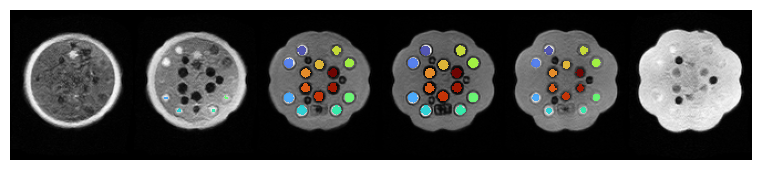

ADC


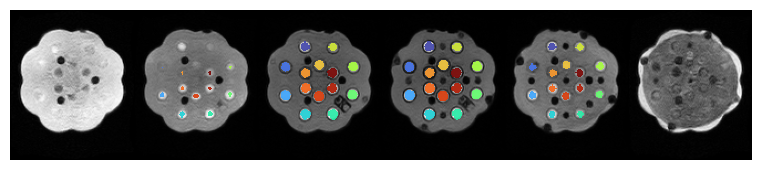

NiCl2


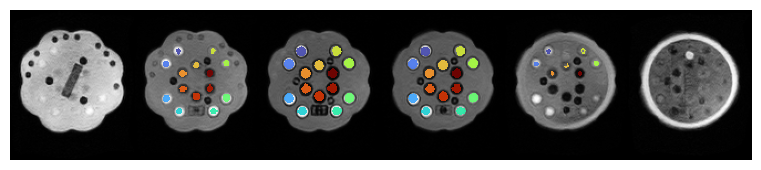

In [78]:
print("MnCl2")
axi.plot(axis=2, overlay=MnCl2_seg, slices=np.arange(11,17))
print("ADC")
axi.plot(axis=2, overlay=ADC_seg, slices=np.arange(16,22))
print("NiCl2")
axi.plot(axis=2, overlay=NiCl2_seg, slices=np.arange(23,29))

#### 2. Python interface

In [41]:
from ghost.phantom import Caliber137

Exhaustive initializer


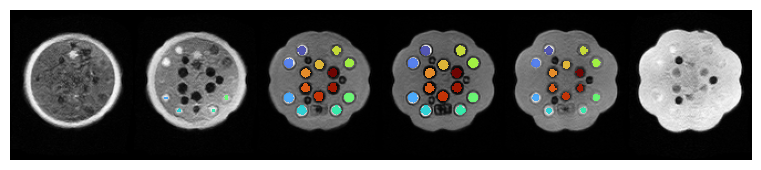

In [87]:
phantom = Caliber137()

# 1. Register the data to the phantom
inv, fwd = phantom.reg_to_phantom(axi, do_syn=False, weighting='T2w')

# 2. Use inverse affine to warp seg to phantom space
seg = phantom.warp_seg(axi, seg='T2mimics', xfm=inv)

axi.plot(axis=2, overlay=seg, slices=np.arange(11,17))

The same approach is used for any other mask.